<img src="files/model_1_outline.png">

sequence generator shape (corrected) (b, n, w, h, c)

## Changes: 
### Use camera 2
### Trim to 2 seconds

In [1]:
import os
import glob
import keras

In [2]:
# Load the TensorBoard notebook extension
import tensorflow as tf
import datetime

In [18]:
# from patrice's blogpost
from keras_video import VideoFrameGenerator

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
classes = ['suture_throws', 'hand_ties', 'thread_cuts']
classes.sort()
print(classes)

['hand_ties', 'suture_throws', 'thread_cuts']


In [6]:
# some global params
SIZE = (100, 100) # height and width of frame pxl by pxl
CHANNELS = 3 # RGB or whatever
NBFRAME = 5 # num frames in sequence 
BS = 8 # Batch size

In [21]:
# pattern to get videos and classes
# glob_pattern='../data_v2_1_model_1_2/model_data/{classname}/*.avi'

glob_pattern = r"C:\Users\calvinap\Box\Pugh Lab Shared Drive\Temp files\data_v2_1_model_1_2\model_data\{classname}\*.avi"

In [22]:
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

In [23]:
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.33, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

class hand_ties, validation count: 129, train count: 264
class suture_throws, validation count: 129, train count: 264
class thread_cuts, validation count: 129, train count: 264
Total data: 3 classes for 792 files for train


In [24]:
# getting validation data
valid = train.get_validation_generator()

Total data: 3 classes for 387 files for validation


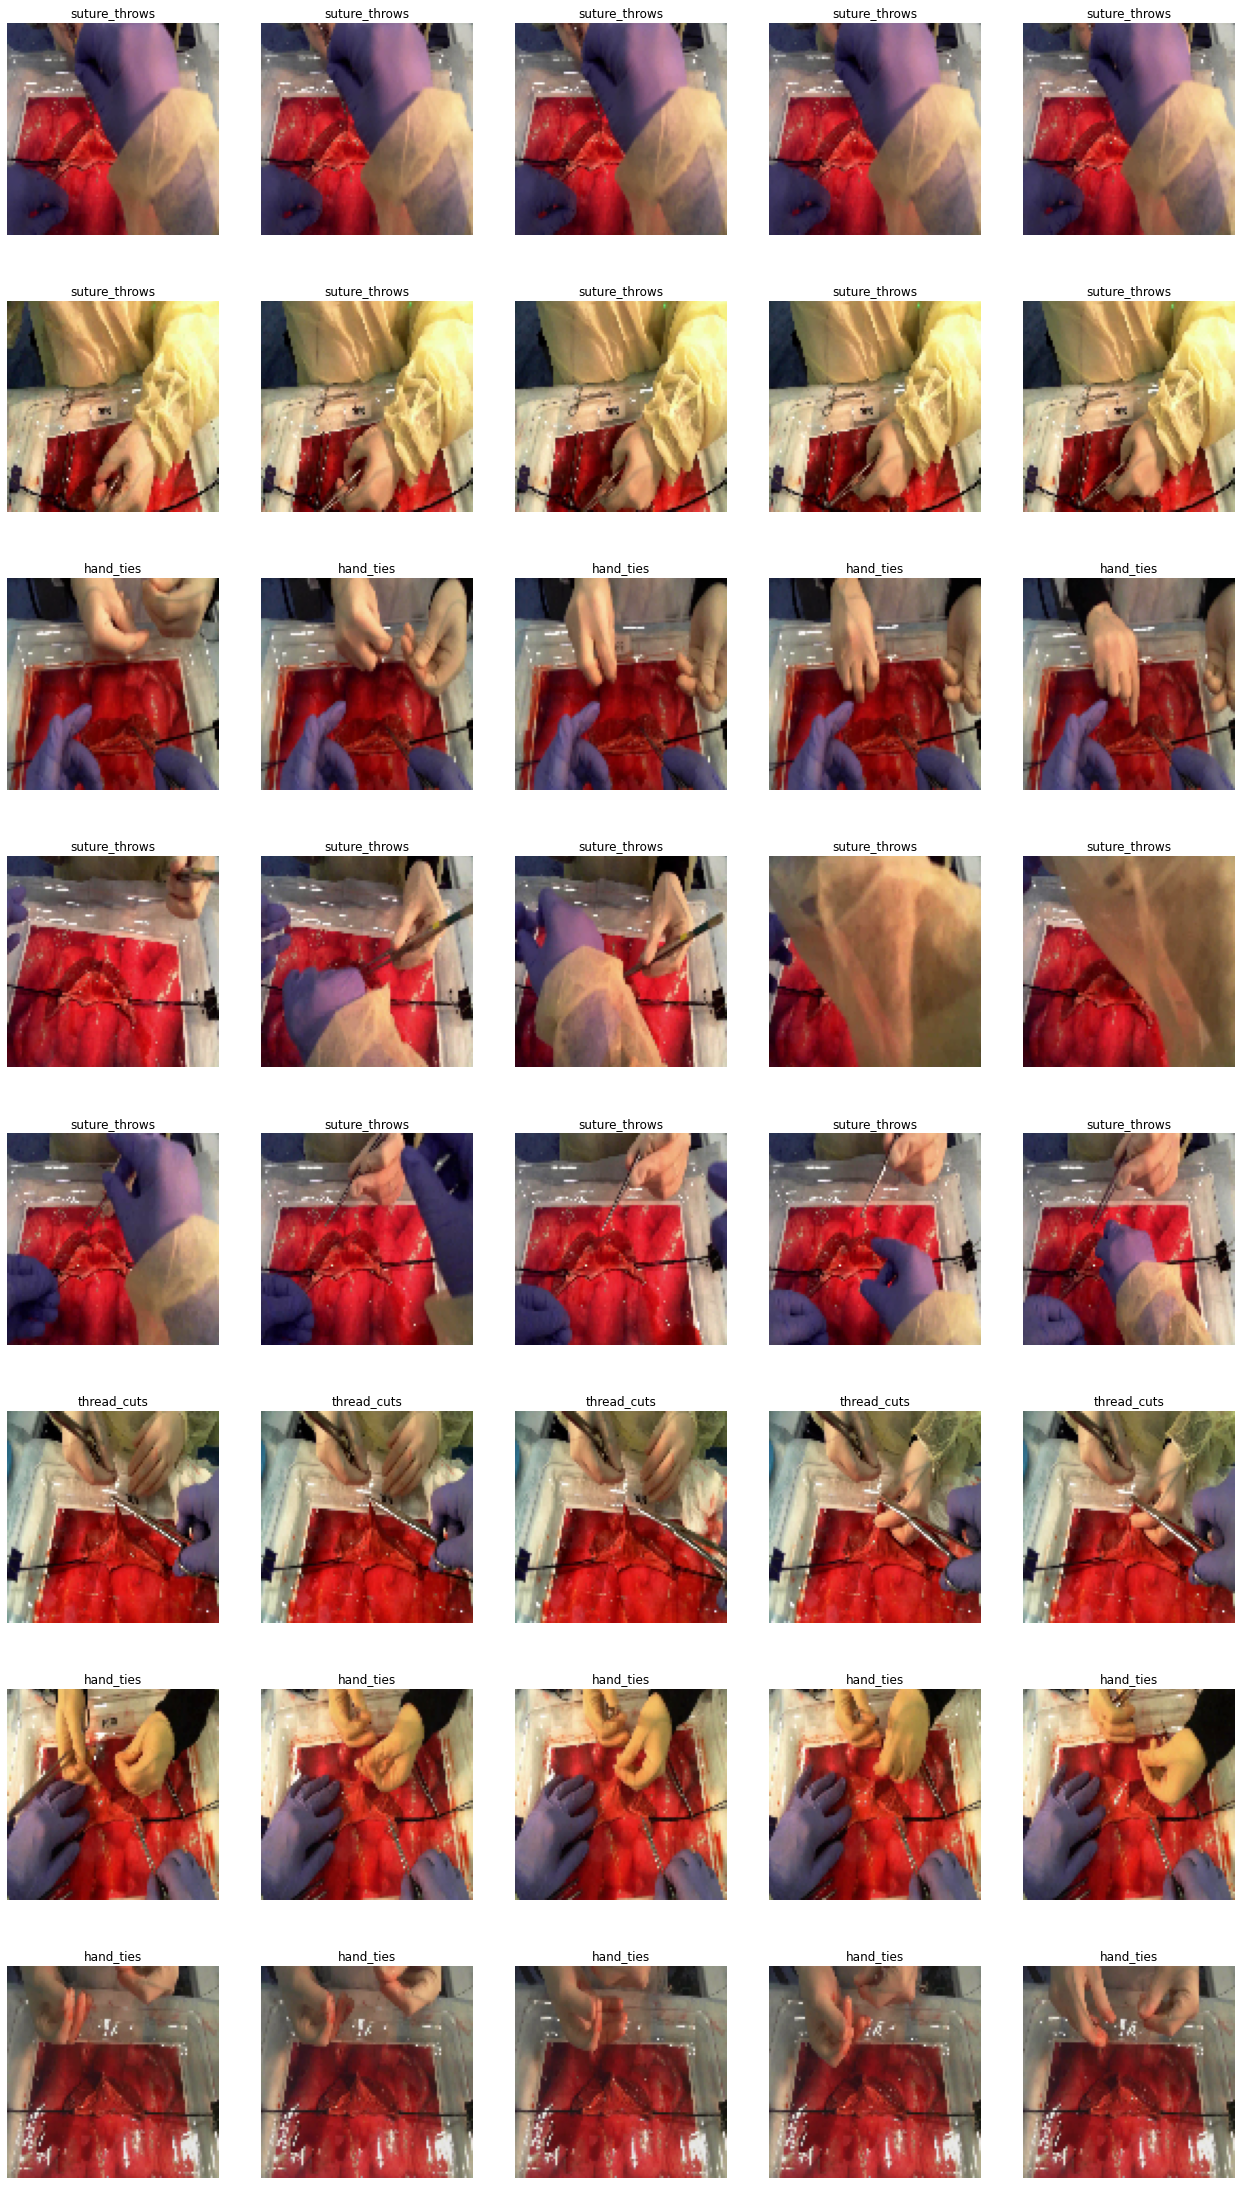

In [25]:
import keras_video.utils
keras_video.utils.show_sample(train)

## BUILD CONV NET

In [26]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
def build_mobilenet(shape=(224, 224, 3), nbout=3):
    model = keras.applications.mobilenet.MobileNet(
        include_top=False,
        input_shape=shape,
        weights='imagenet')
    # Keep 9 layers to train﻿﻿
    trainable = 9
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True
    output = GlobalMaxPool2D()
    return keras.Sequential([model, output])

## Build GRU

In [27]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
# Shape (5, 112, 112, 3) 5 - time sequence length 112x112 = height vs width 3 - num channels
def action_model(shape=(5, 112, 112, 3), nbout=3):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_mobilenet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    # KEY = allows you to add a time sequence to a layer one at a time
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

## this is where you tell the model how to train - loss function, weight update mechanism

In [28]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
# action model - GRU set up for Time shifted CNN
model = action_model(INSHAPE, len(classes))

# this is where you tell the model how to train - loss function, weight update mechanism
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

## epochs, call backs

In [29]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [30]:
EPOCHS=100

# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'model2_0_chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
37/99 [==========>...................] - ETA: 1:58 - loss: 1.1756 - acc: 0.3111

KeyboardInterrupt: 